In [3]:
import numpy as np
import nibabel as nib
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
# sys.path.insert(1, '/host/cassio/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
from pathlib import Path
resourcesdir=str(Path(utils.__file__).parents[1]) + '/resources'
import importlib
import matplotlib.pyplot as plt

In [4]:
# for l,label in enumerate(['hipp','dentate']):
#     for d,den in enumerate(['2mm','1mm','0p5mm','unfoldiso']):
#         cmd = f'wb_command -surface-vertex-areas {resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-{label}_midthickness.surf.gii {resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-{label}_surfarea.shape.gii'
#         !{cmd}

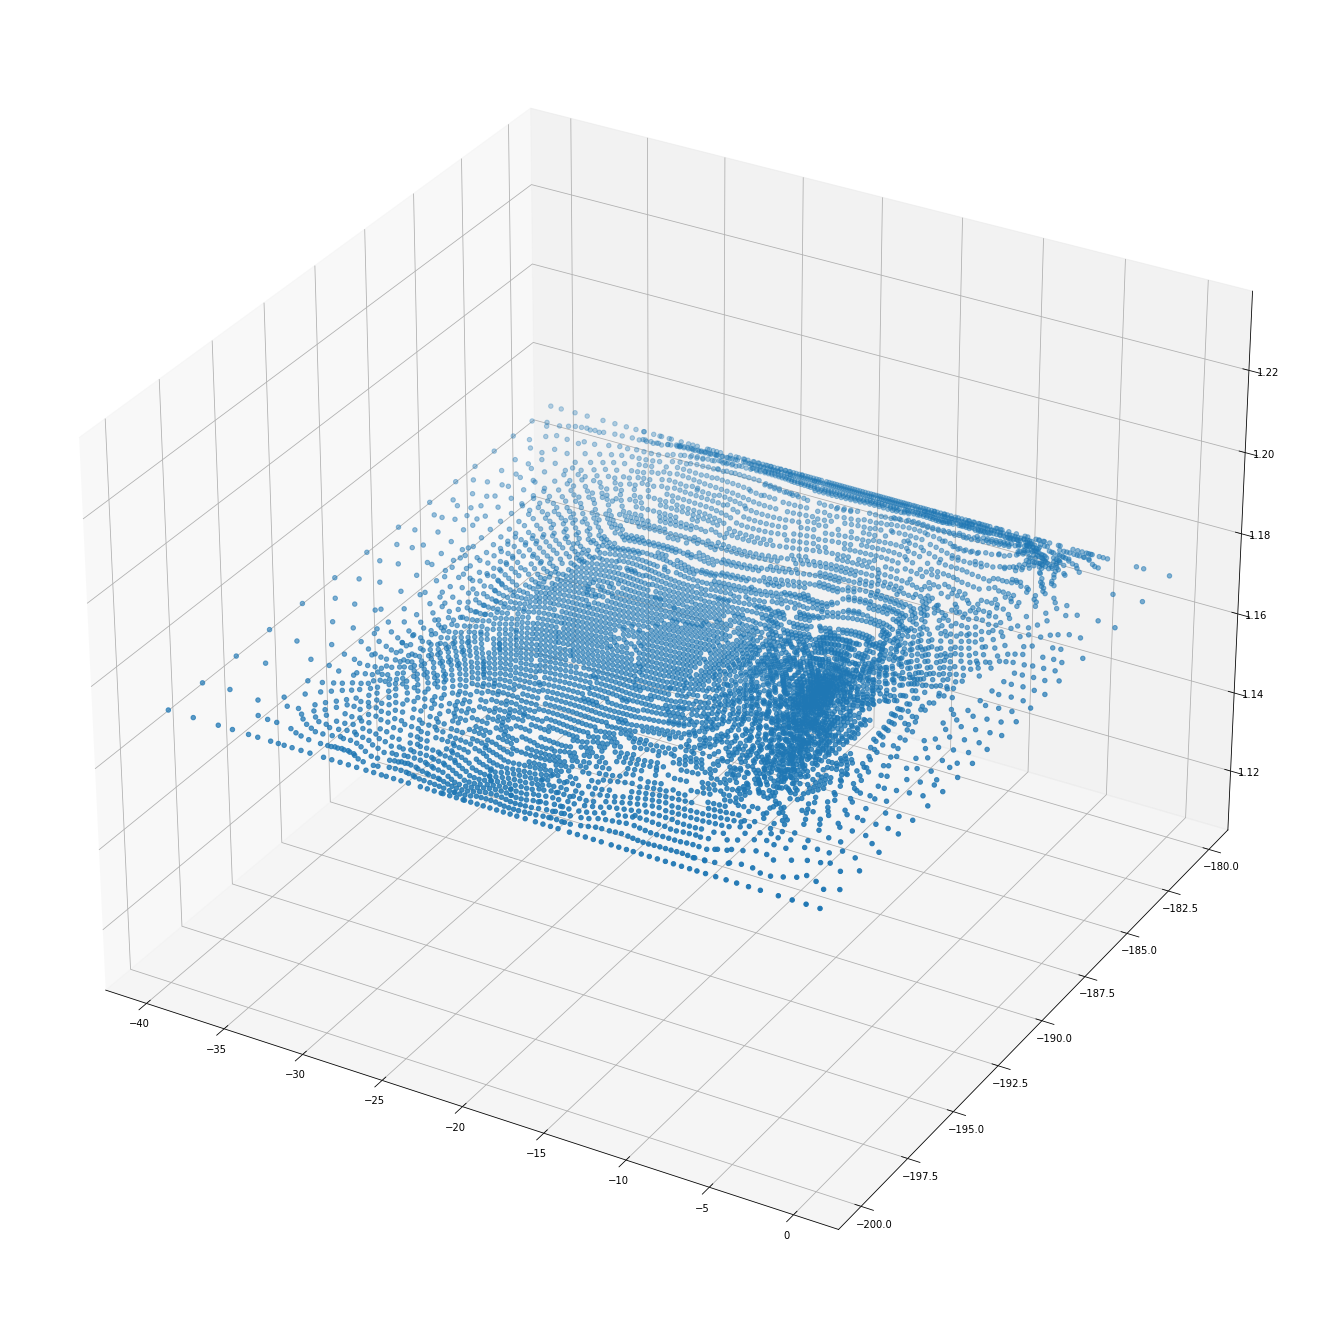

In [5]:
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold'
sub = 'HC002'
ses='ses-01'
uses = '_'+ses 
label='hipp'
den='0p5mm'
hemi='L'
space='unfold'
gii = nib.load(f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}{uses}_hemi-{hemi}_space-{space}_den-{den}_label-{label}_midthickness.surf.gii')
vertices = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
faces = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0],vertices[:,1],vertices[:,2])

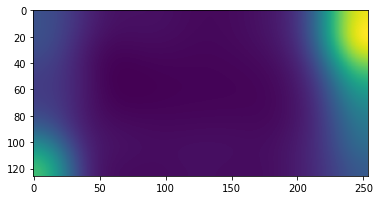

In [6]:
APaxis=0
w = 126 if label=='hipp' else 30 # width of unfolded space
s=15
Pold = vertices[:,APaxis] 
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
from numpy.matlib import repmat


surfarea = nib.load(f'{resourcesdir}/canonical_surfs/tpl-avg_space-unfold_den-{den}_label-{label}_surfarea.shape.gii').darrays[0].data
surfarea,_,_ = utils.density_interp(den, 'unfoldiso', surfarea.flatten(), label)
surfarea = np.reshape(surfarea,(w,254))
surfarea = gaussian_filter(surfarea,sigma=s)
plt.imshow(surfarea)

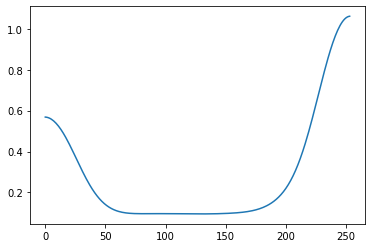

In [23]:
avg_surfarea = np.mean(surfarea,axis=0)

plt.plot(avg_surfarea)

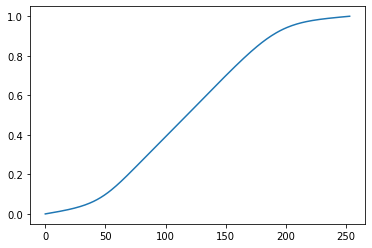

In [24]:
rescalefactor = np.cumsum(1/avg_surfarea)
rescalefactor = rescalefactor - np.min(rescalefactor)
rescalefactor = rescalefactor/np.max(rescalefactor)
plt.plot(rescalefactor)

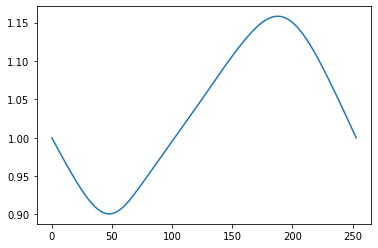

In [25]:
rescalefactor = rescalefactor+1 - np.linspace(0,1,len(rescalefactor))

plt.plot(rescalefactor)

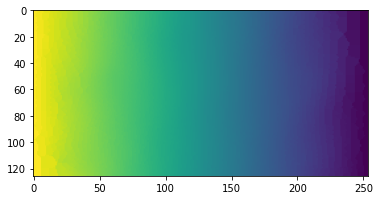

In [26]:
AP,_,_ = utils.density_interp(den, 'unfoldiso', Pold.flatten(), label,'nearest')
plt.imshow(AP.reshape(126,254))

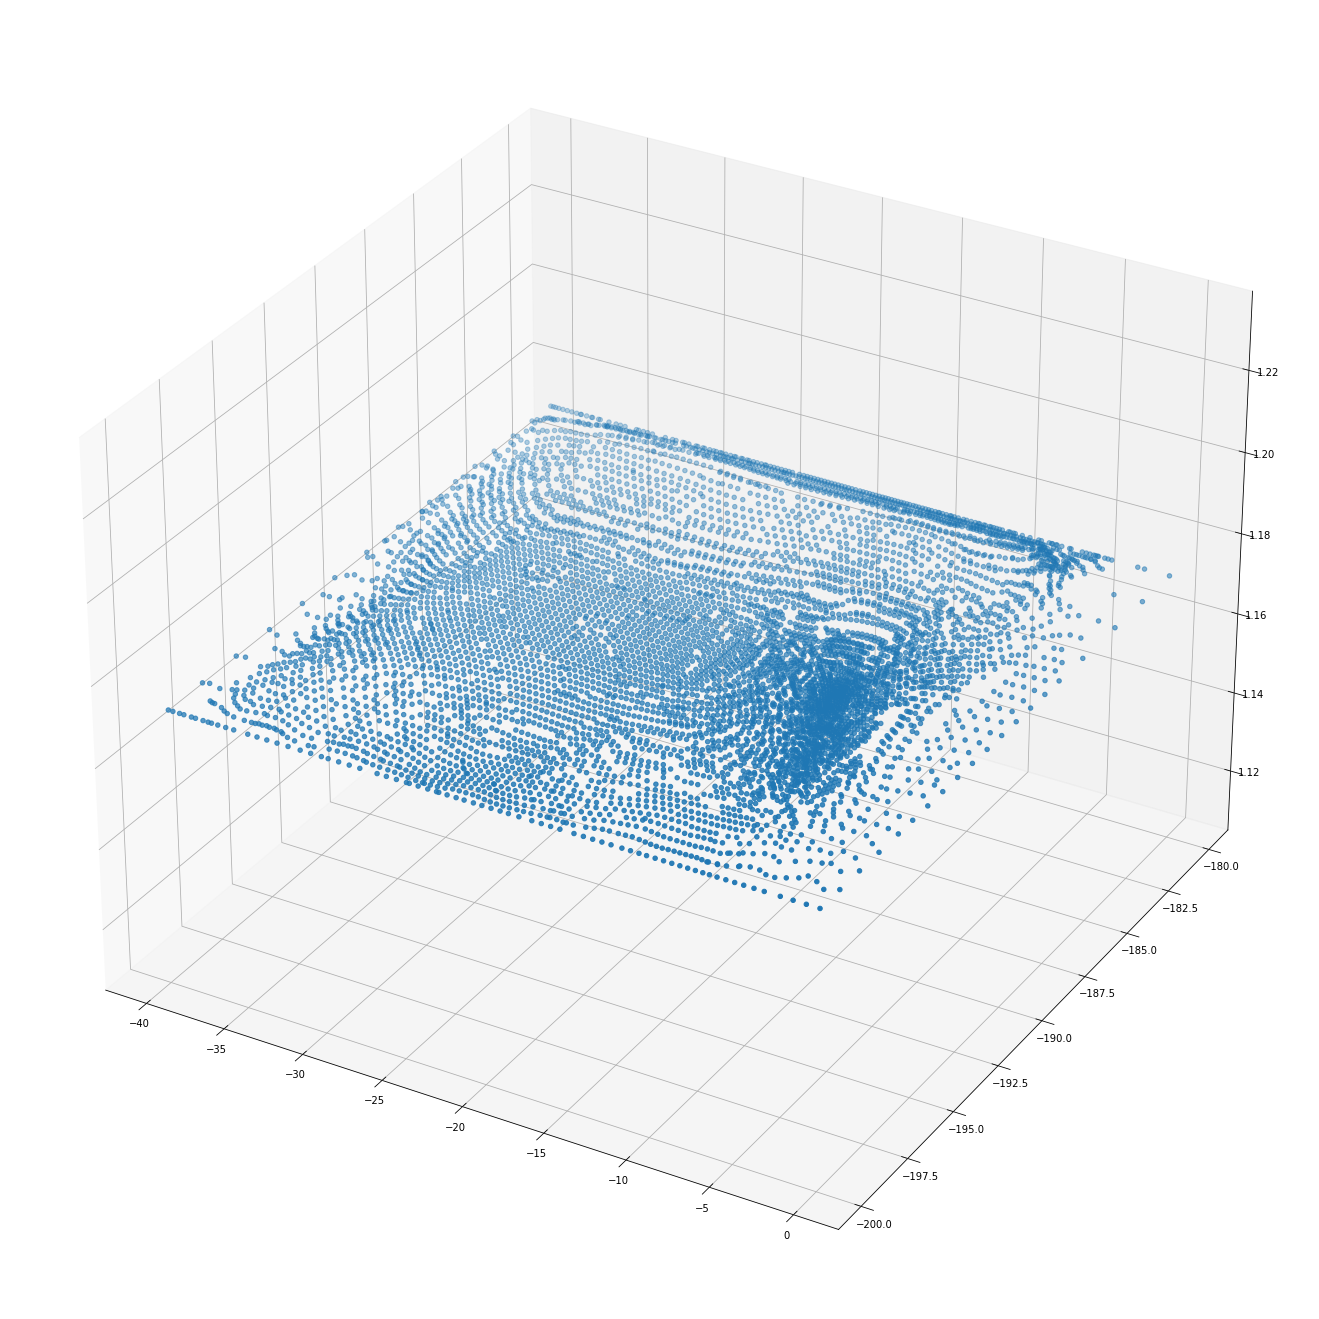

In [27]:
rescalefactor = repmat(rescalefactor,w,1)
rescalefactor,_,_ = utils.density_interp('unfoldiso', den, rescalefactor.flatten(), label,'nearest')

Pnew = Pold * rescalefactor
vertices[:,APaxis] = Pnew

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(projection='3d')
ax.scatter(vertices[:,0],vertices[:,1],vertices[:,2])

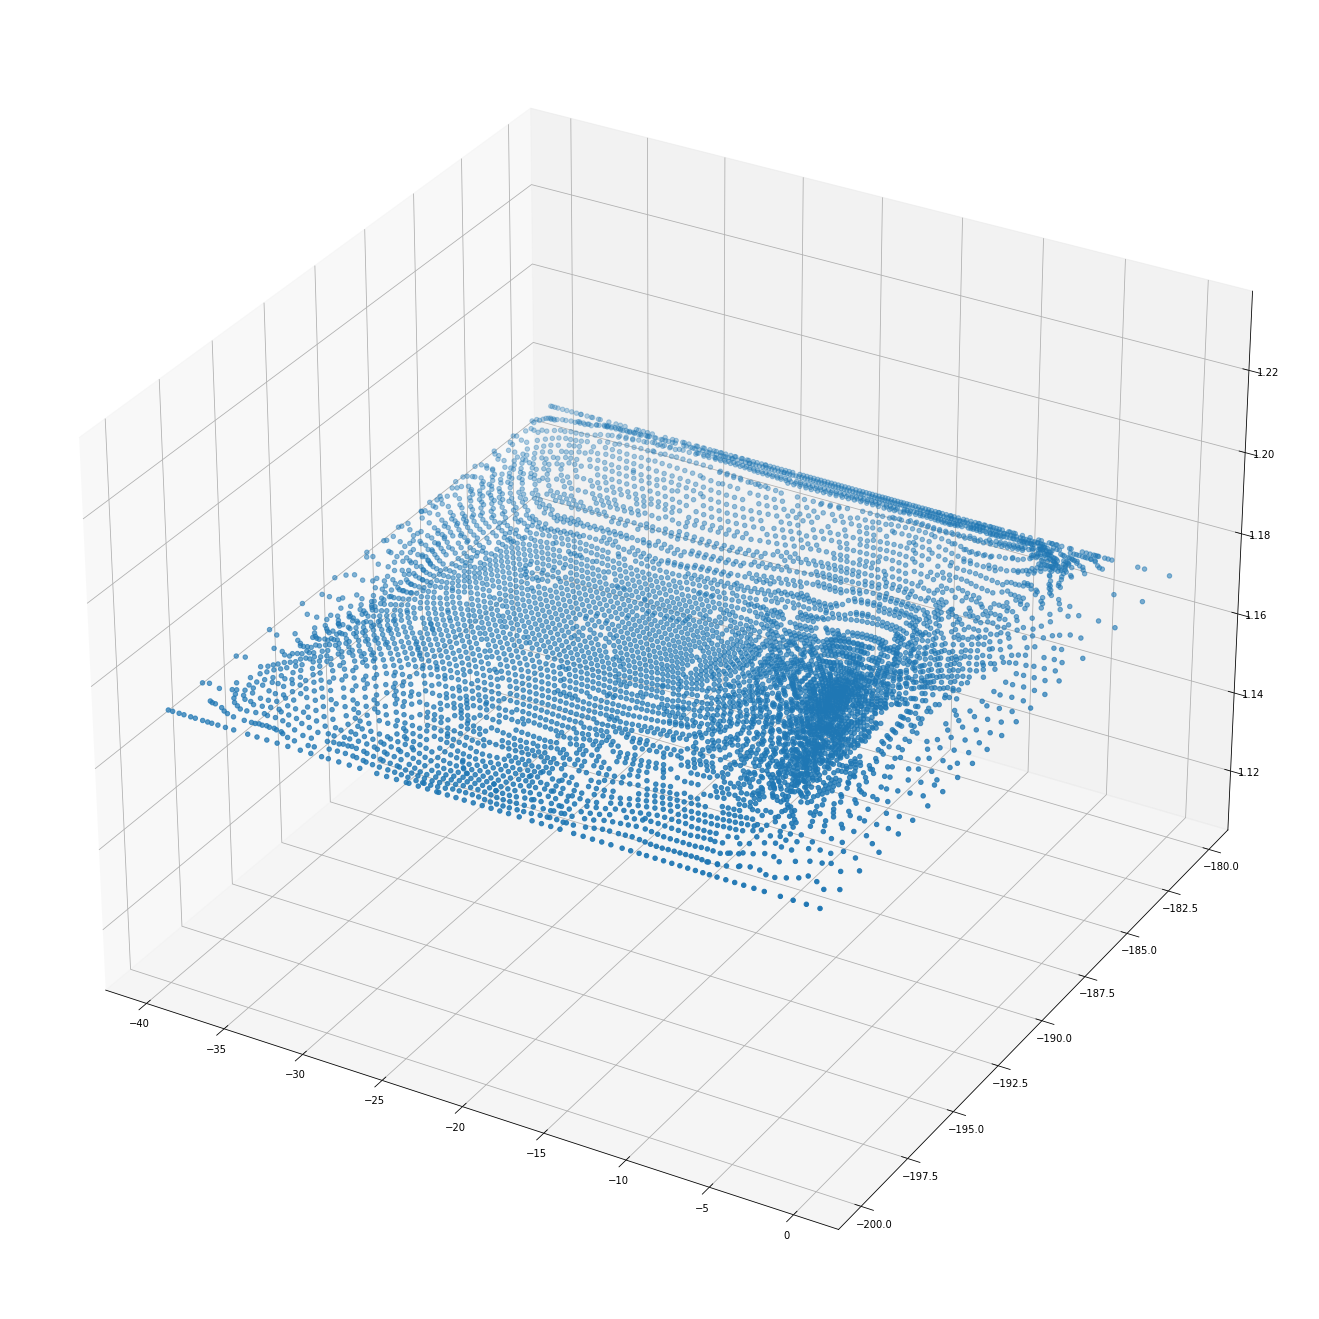

In [28]:
import importlib
importlib.reload(utils)

gii = nib.load(f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}{uses}_hemi-{hemi}_space-{space}_den-{den}_label-{label}_midthickness.surf.gii')
vertices = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
v2 = utils.area_rescale(vertices,den,label,APaxis=0)

fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(projection='3d')
ax.scatter(v2[:,0],v2[:,1],v2[:,2])

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


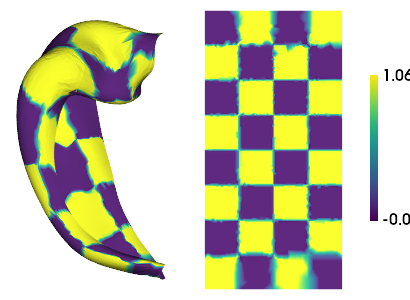

In [29]:
from PIL import Image
testdata = np.kron([[1, 0] * 4, [0, 1] * 4] * 2, np.ones((100, 100)))
testdata = np.array(Image.fromarray(testdata).resize(size=(254,126)))
testdata,_,_ = utils.density_interp('unfoldiso','0p5mm',testdata.flatten(),'hipp')

plotting.surfplot_canonical_foldunfold(testdata, hemis=['L'], labels=['hipp'], den='0p5mm', unfoldAPrescale=False, embed_nb=True, color_bar='right', share='row')

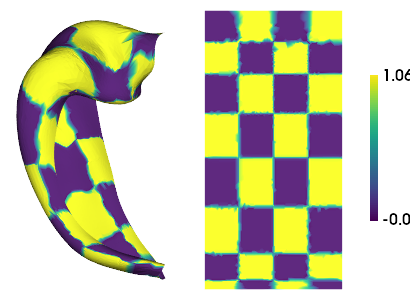

In [30]:
plotting.surfplot_canonical_foldunfold(testdata.flatten(), hemis=['L'], labels=['hipp'], den='0p5mm', unfoldAPrescale=True, embed_nb=True, color_bar='right', share='row')

In [58]:
# test projection to volume

import importlib
importlib.reload(utils)
t = utils.surface_to_volume(np.round(testdata)+1, 'test.nii.gz', '0p5mm', '/export03/data/unfolded_registration/hippunfold_v1.3.0_100um/hippunfold','pli3d','','L','corobl')